# Assignment 1 2AMM10 2023-2024

## Group: [Group 6]
### Member 1: [Luca Mainardi]
### Member 2: [Francesco Brescia]
### Member 3: [Matthew Nana]

In [92]:
main_dir=''

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [94]:
# Variable to enable/disable training
TRAIN_TRIPLET = False
TRAIN_TRIPLET_ROTATION = False

In [95]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [96]:
train_data = load_data(main_dir + 'data/train_data.pkl')

In [97]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [98]:
len(alphabets)

30

In [99]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)

    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()

<Figure size 640x480 with 0 Axes>

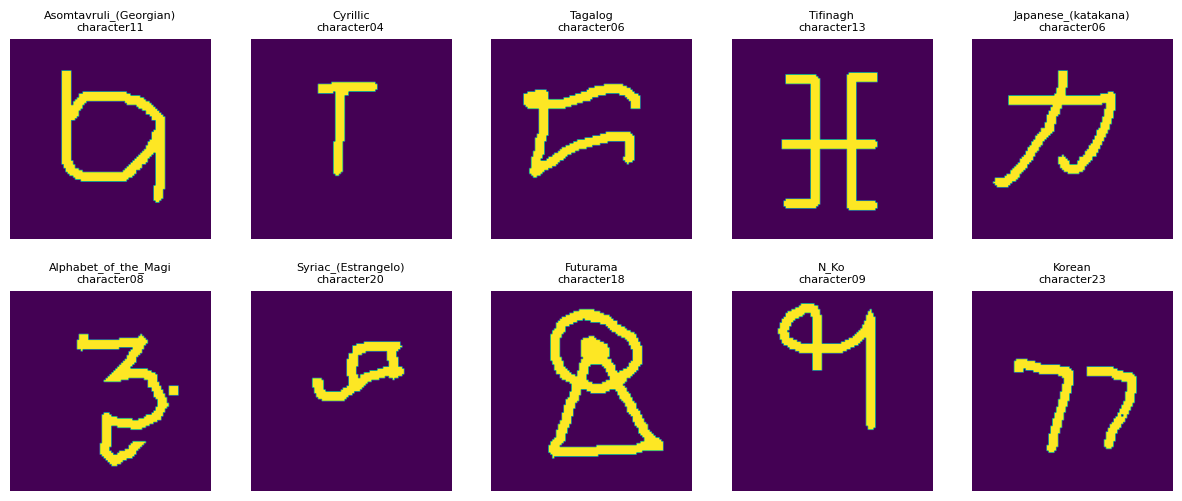

In [100]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torch.utils.data import random_split
from sklearn.preprocessing import LabelEncoder

In [102]:
# DO NOT REMOVE OR MODIFY
# Check if GPU is available and determine the device
if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.cuda.manual_seed_all(42)
else:
    DEVICE = 'cpu'

print(f'The available device is {DEVICE}')

The available device is cpu


## Triplet Network

In [103]:
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        positive_distance = (output1 - output2).pow(2).sum(1)
        negative_distance = (output1 - output3).pow(2).sum(1)
        losses = F.relu(positive_distance - negative_distance + self.margin)
        return losses.mean()

In [104]:
class Lambda(nn.Module):
    """
    A utility class that allows you to create a PyTorch nn.Module from an arbitrary function.
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EmbeddingNet(nn.Module):
    """
    A PyTorch implementation of a Convolutional Neural Network (CNN) for feature extraction or embedding.

    The network consists of three convolutional blocks each followed by a batch normalization, ReLU activation, and max pooling.
    After the convolutional blocks, the tensor is flattened and passed through two fully connected (linear) layers.

    The final output is a 10-dimensional vector which can be used as an embedding of the input.
    """
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

In [105]:
class TripletNet(nn.Module):
    """
    A PyTorch implementation of a Triplet Network for learning useful data embeddings.

    The network takes three inputs - an anchor, a positive of the same class as the anchor, and a negative of a different class.
    Each of these inputs is passed through the same embedding network, and the output embeddings are returned.

    The goal during training is to learn an embedding such that the distance between the anchor and positive is less than the distance between the anchor and negative.
    """
    def __init__(self, embedding_net):
        """Initializes the TripletNet with the given embedding network."""
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        """Forward pass for the TripletNet."""
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        """Returns the embeddings of the input."""
        return self.embedding_net(x)

In [106]:
class TripletDataset(Dataset):
    """
    A custom dataset class for creating triplets of images with their corresponding labels.

    Args:
        data_dict (dict): A dictionary containing the image data organized by alphabet and character.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.

    Attributes:
        images (list): A list of all the images in the dataset.
        labels (list): A list of labels corresponding to each image.
        transform (callable): The transform function to be applied to the images.
        encoder (LabelEncoder): An instance of the LabelEncoder class for encoding the labels.
        triplets (list): A list of triplets of images with the anchor, positive and negative images.
    """
    def __init__(self, data_dict, transform=None, device=DEVICE):

        np.random.seed(42)

        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

        # Create list with triplets of images, where the first two images are similar and the third is different
        # Consider all the pairs of positive images and sample two negative images for each pair
        self.triplets = []

        for i in tqdm(range(len(self.images))):
            for j in range(i+1, len(self.images)):
                if self.labels[i] == self.labels[j]:
                    for _ in range(2):
                        # sample the third image
                        index = np.random.choice(len(self.images))
                        # If the third image is from the same class, sample another one
                        while self.labels[index] == self.labels[i]:
                            index = np.random.choice(len(self.images))
                        self.triplets.append((self.images[i], self.images[j], self.images[index]))



    def __len__(self):
        """
        Returns the total number of triplets in the dataset.
        """
        return len(self.triplets)

    def __getitem__(self, idx):
        """
        Returns the triplet of images at the given index.
        """
        img1, img2, img3 = self.triplets[idx]

        if self.transform:
            to_pil = transforms.ToPILImage()
            img1 = to_pil(img1)
            img1 = self.transform(img1)
            img2 = to_pil(img2)
            img2 = self.transform(img2)
            img3 = to_pil(img3)
            img3 = self.transform(img3)

        return img1, img2, img3

In [107]:
# Function to compute distance of the Triplet network
def compute_distance_triplet(output1, output2, output3):
    """
    Computes the Distance for a triplet.

    The function takes as input the output embeddings of an anchor, positive, and negative example from a triplet network.
    It computes the Euclidean distance between the anchor and positive examples (distance_positive) and between the anchor and negative examples (distance_negative).
    It performs the difference and infince the average per batch.

    Parameters:
    output1 (torch.Tensor): The output embedding of the anchor example.
    output2 (torch.Tensor): The output embedding of the positive example.
    output3 (torch.Tensor): The output embedding of the negative example.

    Returns:
    float: The distance.
    """
    # Compute the Euclidean distance between output1 and output2
    distance_positive = F.pairwise_distance(output1, output2)

    # Compute the Euclidean distance between output1 and output3
    distance_negative = F.pairwise_distance(output1, output3)

    # Compute the difference between positive and negative distances
    distance = distance_negative - distance_positive

    # Compute the average distance per batch
    average_distance = torch.mean(distance)

    return average_distance.item()

In [108]:
# Function to create Triplet dataset
def create_triplet_dataset(data_dict, transform=None):
    """
    Creates a Triplet dataset from the given data dictionary.
    """
    return TripletDataset(data_dict=data_dict, transform=transform)

# Function to train Triplet network
def train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=DEVICE):
    """
    Trains a triplet network for a specified number of epochs.

    The function takes as input a triplet network, training and validation data loaders, number of epochs, and learning rate.
    It uses the Adam optimizer and a custom TripletLoss criterion.
    For each epoch, it iterates over the training data, computes the loss and backpropagates the gradients.
    It also computes the AUC-ROC for each batch and keeps a running total.
    After each epoch, it evaluates the network on the validation data and computes the average loss and AUC-ROC.

    Parameters:
    triplet_network (nn.Module): The triplet network to train.
    train_loader (DataLoader): The DataLoader for the training data.
    val_loader (DataLoader): The DataLoader for the validation data.
    num_epochs (int, optional): The number of epochs to train for. Default is 10.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    None
    """
    criterion = TripletLoss().to(device)
    optimizer = optim.Adam(triplet_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        triplet_network.train()

        running_loss = 0.0
        running_distance = 0.0
        batch_count = 0

        for img1, img2, img3 in progress_bar:
            optimizer.zero_grad()
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
            output1, output2, output3 = triplet_network(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
            running_distance += distance
            batch_count += 1

            # Update the progress bar with the current loss and distance
            progress_bar.set_postfix({"loss": running_loss / batch_count, "distance": running_distance / batch_count})

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Distance: {running_distance/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        triplet_network.eval()
        running_val_loss = 0.0
        running_val_distance = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, img3 in progress_bar:
                img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
                output1, output2, output3 = triplet_network(img1, img2, img3)
                val_loss = criterion(output1, output2, output3)
                running_val_loss += val_loss.item()
                val_distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
                running_val_distance += val_distance
                batch_count += 1

                # Update the progress bar with the current loss and distance
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_distance": running_val_distance / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Distance: {running_val_distance/len(val_loader)}")

In [109]:
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),
    transforms.Grayscale(num_output_channels=1)
])

In [110]:
# Create Triplet network
triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)

In [111]:
#  Create Triplet dataset
triplet_dataset = create_triplet_dataset(train_data, transform=preprocess)

# Define the size of the validation set
val_size = int(0.2 * len(triplet_dataset))  # 20% of the dataset
train_size = len(triplet_dataset) - val_size

# Create train and validation sets
generator = torch.Generator().manual_seed(42)
triplet_train_dataset, triplet_val_dataset = random_split(triplet_dataset, [train_size, val_size], generator=generator)

# Create data loaders
train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(triplet_val_dataset, batch_size=32, shuffle=False)

print(f"Num of training triplets: {len(triplet_train_dataset)}")
print(f"Num of validation triplets: {len(triplet_val_dataset)}")

100%|██████████| 19280/19280 [00:26<00:00, 736.62it/s] 


Num of training triplets: 293056
Num of validation triplets: 73264


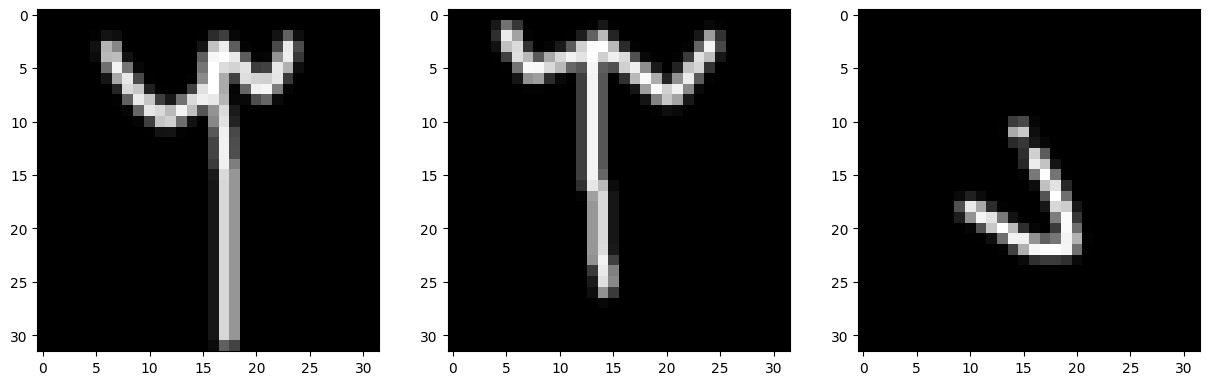

In [112]:
def plot_image(img):
    if img.shape[0] == 1:
        # Grayscale image
        plt.imshow(img.squeeze(0), cmap='gray')
    else:
        # RGB image
        plt.imshow(img.permute(1, 2, 0))

# Plot a random triplet of images from the validation set
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(len(triplet_val_dataset))
img1, img2, img3 = triplet_val_dataset[random_idx]
plt.subplot(1, 3, 1)
plot_image(img1)
plt.subplot(1, 3, 2)
plot_image(img2)
plt.subplot(1, 3, 3)
plot_image(img3)

In [113]:
# Train the Triplet network
if TRAIN_TRIPLET:
    train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=5, learning_rate=0.0001)
    # Save the trained Siamese network
    torch.save(triplet_network.state_dict(), main_dir + 'triplet_network.pth')

In [114]:
# Load the trained Triplet Network
triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)
triplet_network.load_state_dict(torch.load(main_dir + 'triplet_network.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

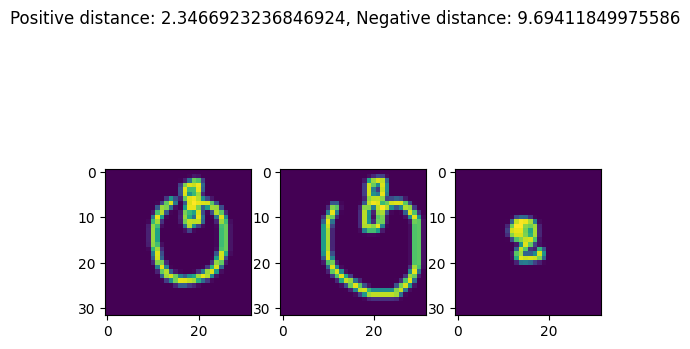

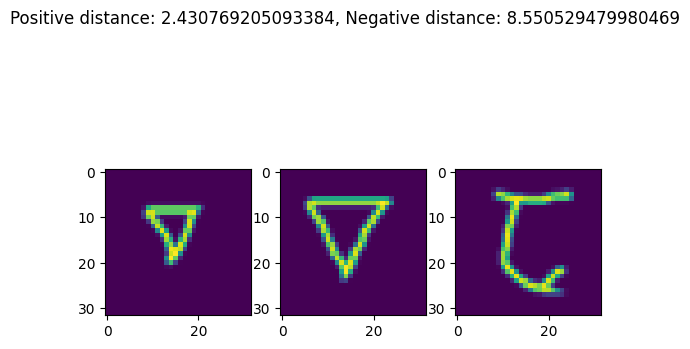

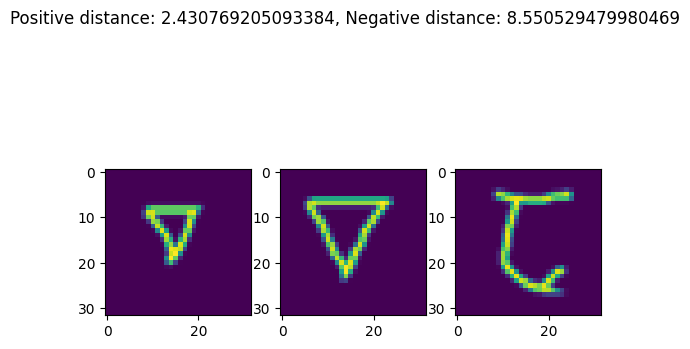

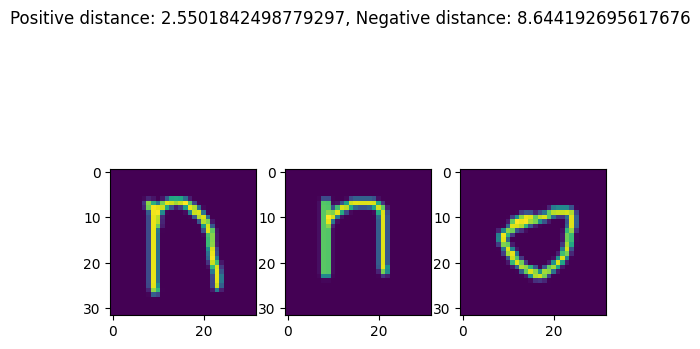

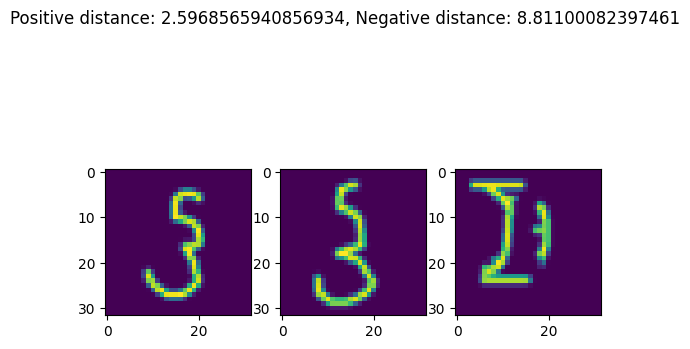

In [115]:
# Visualize some triplets with their distances
import matplotlib.pyplot as plt
import random
import itertools

# Test the trained Siamese network on some random pairs of images
def visualize_predictions_triplet_network(triplet_network, val_loader, num_pairs=5, device=DEVICE):
    triplet_network.eval()
    for _ in range(num_pairs):
        # Create a new iterator for the validation loader
        dataiter = iter(val_loader)
        # Select a random batch
        batch_idx = random.randint(0, len(val_loader)-1)
        # Reset the iterator and advance to the random batch
        dataiter = itertools.islice(dataiter, batch_idx, None)
        img1, img2, img3 = next(dataiter)

        img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
        output1, output2, output3 = triplet_network(img1, img2, img3)

        distance_positive = F.pairwise_distance(output1, output2)
        distance_negative = F.pairwise_distance(output1, output3)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img1[0].cpu().numpy().transpose((1, 2, 0)))
        ax2.imshow(img2[0].cpu().numpy().transpose((1, 2, 0)))
        ax3.imshow(img3[0].cpu().numpy().transpose((1, 2, 0)))
        fig.suptitle(f"Positive distance: {torch.mean(distance_positive).item()}, Negative distance: {torch.mean(distance_negative).item()}")
        plt.show()

visualize_predictions_triplet_network(triplet_network, val_loader)

In [116]:
# Function to preprocess an image
def preprocess_image(image, preprocess, toPILImage):
    """
    Preprocesses the image for the network.
    
    :param image: Input image.
    :param preprocess: Preprocessing transformations.
    :param toPILImage: Transform to convert tensor to PIL image.
    :return: Preprocessed image tensor.
    """
    image = toPILImage(image)
    return preprocess(image).unsqueeze(0)

In [117]:
# Function to compute embeddings for a list of images
def compute_embeddings(images, triplet_network, preprocess, toPILImage, device):
    """
    Computes embeddings for a list of images.
    
    :param images: List of images.
    :param triplet_network: The network to compute embeddings.
    :param preprocess: Preprocessing transformations.
    :param toPILImage: Transform to convert tensor to PIL image.
    :param device: Device to run the network on.
    :return: Tensor of embeddings.
    """
    embeddings = []
    for image in images:
        image = preprocess_image(image, preprocess, toPILImage).to(device)
        embedding = triplet_network.get_embedding(image)
        embeddings.append(embedding)
    return torch.cat(embeddings)

In [118]:
# Evaluation method
def evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=True, device=DEVICE):
    """
    Evaluates the Triplet network on the test data.

    :param triplet_network: The trained Triplet network.
    :param data_dict_test: Dictionary with test data. Contains keys 'annotated_images', 
                           'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
    :param K: Number of most similar images to consider.
    :param print_alphabet_accuracy: Flag to print accuracy for each alphabet.
    :param device: Device to perform computations on ('cuda' or 'cpu').
    :return: Overall accuracy of the network on the test data.
    """
    triplet_network.eval()
    correct_predictions = 0
    num_images = 0

    toPILImage = transforms.ToPILImage()

    with torch.no_grad():
        for alphabet in tqdm(data_dict_test['annotated_images'].keys()):
            correct_predictions_alphabet = 0

            # Preprocess and compute embeddings for annotated images
            annotated_images = data_dict_test['annotated_images'][alphabet]
            annotated_labels = data_dict_test['annotated_images_labels'][alphabet]
            annotated_embeddings = compute_embeddings(annotated_images, triplet_network, preprocess, toPILImage, device)

            unseen_images = data_dict_test['unseen_images'][alphabet]
            unseen_labels = data_dict_test['unseen_images_labels'][alphabet]

            for i, unseen_image in enumerate(unseen_images):
                # Preprocess and compute embedding for unseen image
                embedding_unseen = compute_embeddings([unseen_image], triplet_network, preprocess, toPILImage, device)

                # Compute distances
                distances = F.pairwise_distance(embedding_unseen, annotated_embeddings)
                distances = distances.cpu().numpy()

                # Get the indices of the K smallest distances
                most_similar_indices = np.argsort(distances)[:K]
                # Get the corresponding labels
                most_similar_labels = [annotated_labels[idx] for idx in most_similar_indices]

                # Get the actual label of the unseen image
                actual_label = unseen_labels[i]

                if actual_label in most_similar_labels:
                    correct_predictions += 1
                    correct_predictions_alphabet += 1
                num_images += 1

            accuracy_alphabet = correct_predictions_alphabet / len(unseen_images)
            if print_alphabet_accuracy:
                print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet:.4f}")

    accuracy = correct_predictions / num_images
    return accuracy


## Testing

In [119]:
# load the test data:

data_dict_test = load_data(main_dir + 'data/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [120]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Mongolian annotated images: torch.Size([30, 1, 105, 105])
Number of Mongolian annotated labels: 30
Shape of Mongolian unseen images: torch.Size([570, 1, 105, 105])
Number of Mongolian unseen labels: 570. Use the unseen labels only for evaluating your model!


In [121]:
num_classes_test = len(set(alphabet_annotated_labels))
num_classes_test

30

In [122]:
alphabet_annotated.shape

torch.Size([30, 1, 105, 105])

### Random Guessing Baseline

In [123]:
def random_prediction(data_dict_test):
    """
    This function performs random prediction on a set of unseen images.
    The prediction is done by randomly selecting a label from the annotated images and checking if it matches the actual label of the unseen image. 
    This process is repeated for different values of k (number of random labels to select). The function calculates and 
    prints the accuracy of the random prediction for each value of k.

    Parameters:
    data_dict_test (dict): A dictionary containing the test data. The dictionary has the following structure:
        - 'annotated_images': A dictionary where the keys are the names of the alphabets and the values are 
                              lists of annotated images for each alphabet.
        - 'annotated_images_labels': A dictionary where the keys are the names of the alphabets and the values 
                                      are lists of labels corresponding to the annotated images.
        - 'unseen_images': A dictionary where the keys are the names of the alphabets and the values are lists 
                           of unseen images for each alphabet.
        - 'unseen_images_labels': A dictionary where the keys are the names of the alphabets and the values are 
                                   lists of labels corresponding to the unseen images.
    """
    
    total_images = sum([len(images) for images in data_dict_test['unseen_images'].values()])

    for k in [1, 2, 4, 8]:
        total_correct_predictions = 0
        for alphabet in tqdm(data_dict_test['annotated_images'].keys()):
            correct_predictions_alphabet = 0
            unseen_images = data_dict_test['unseen_images'][alphabet]
            unseen_labels = data_dict_test['unseen_images_labels'][alphabet]

            for i, unseen_image in enumerate(unseen_images):
                # Get a random label from the annotated images
                random_labels = random.sample(data_dict_test['annotated_images_labels'][alphabet], k)

                # Check if the actual label is in the list of random labels
                if unseen_labels[i] in random_labels:
                    correct_predictions_alphabet += 1

            total_correct_predictions += correct_predictions_alphabet

        total_accuracy = total_correct_predictions / total_images
        print(f'Accuracy for k={k}: {total_accuracy}')

random_prediction(data_dict_test)


100%|██████████| 20/20 [00:00<00:00, 816.89it/s]


Accuracy for k=1: 0.02915102627585656


100%|██████████| 20/20 [00:00<00:00, 794.09it/s]


Accuracy for k=2: 0.061576551393658654


100%|██████████| 20/20 [00:00<00:00, 670.13it/s]


Accuracy for k=4: 0.12610813832760961


100%|██████████| 20/20 [00:00<00:00, 431.32it/s]

Accuracy for k=8: 0.23736123312834437


### Evaluate Triplet Network

In [124]:
print_alphabet_accuracy = False

In [125]:
accuracy_1 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_2 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=2, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_4 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_8 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=8, print_alphabet_accuracy=print_alphabet_accuracy)

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [126]:
print(f"Accuracy for k=1: {accuracy_1}")
print(f"Accuracy for k=2: {accuracy_2}")
print(f"Accuracy for k=4: {accuracy_4}")
print(f"Accuracy for k=8: {accuracy_8}")

Accuracy for k=1: 0.6493890264355882
Accuracy for k=2: 0.7977797300535101
Accuracy for k=4: 0.8996885232808881
Accuracy for k=8: 0.9586295024359077


### Visualise Predictions

Number of images in alphabet Gurmukhi: 45


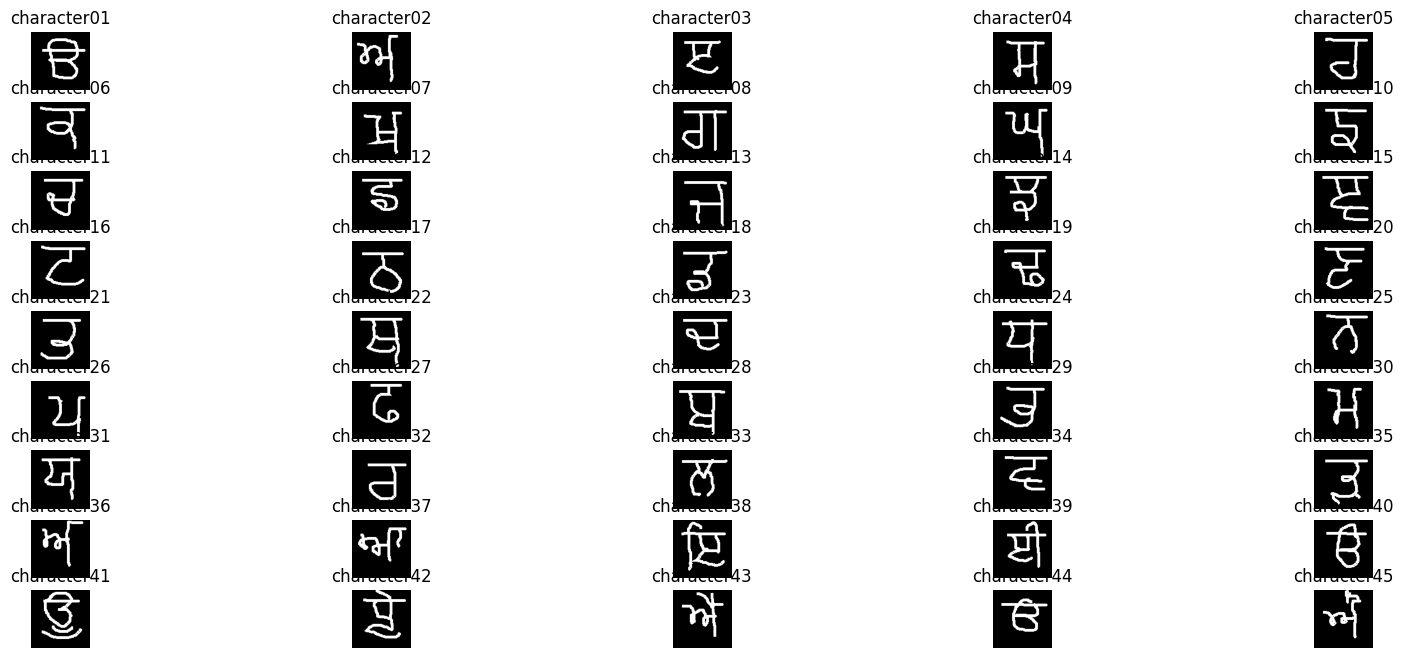

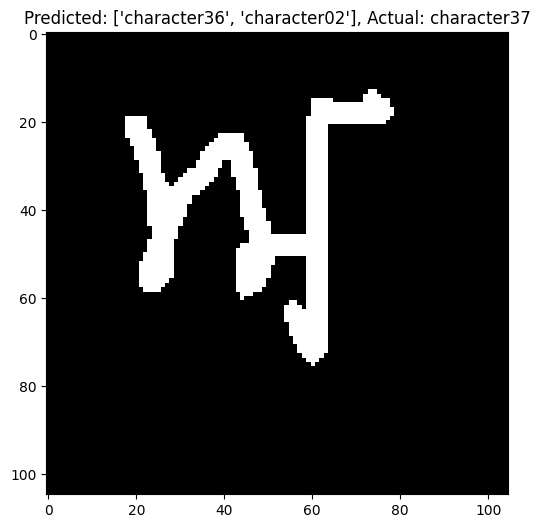

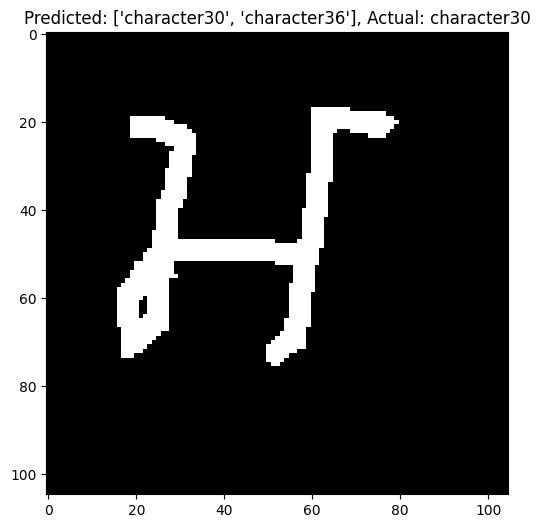

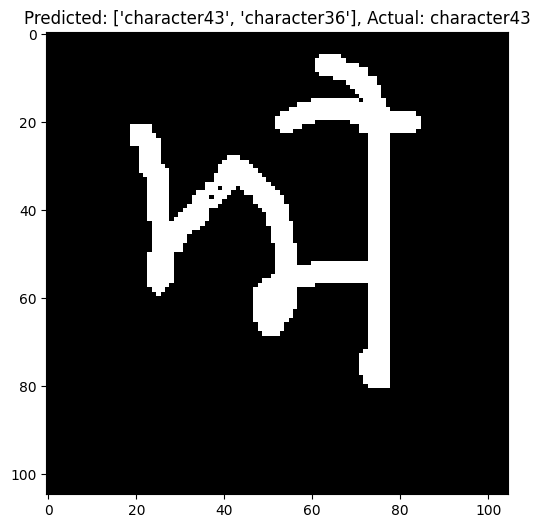

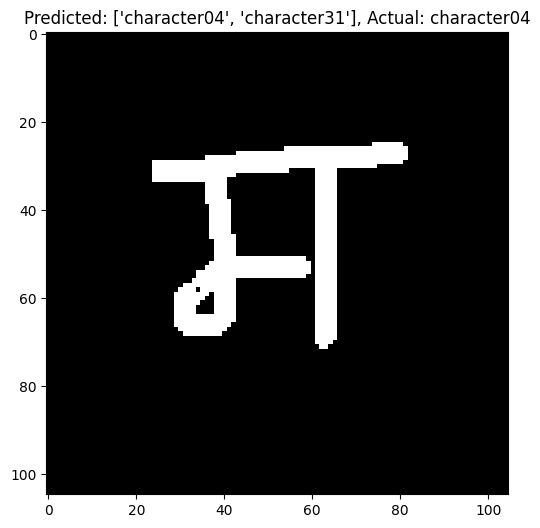

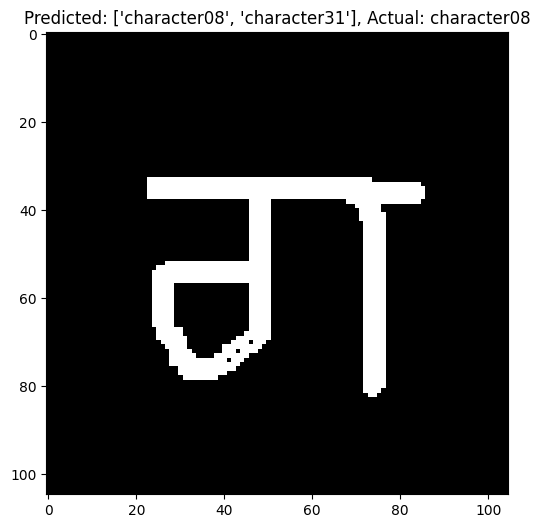

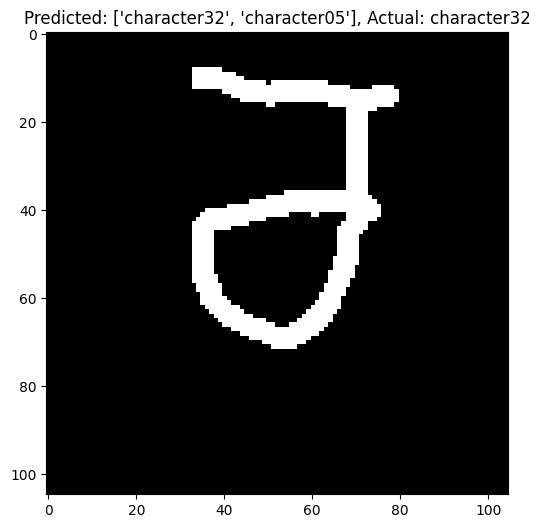

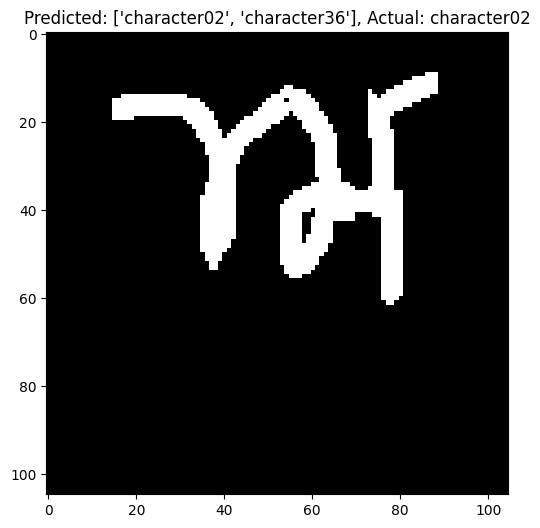

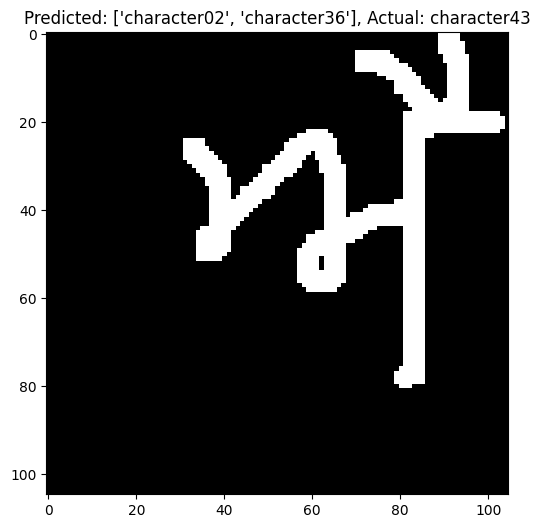

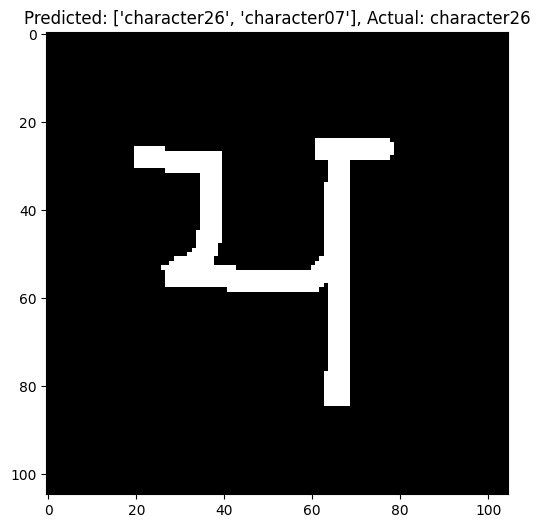

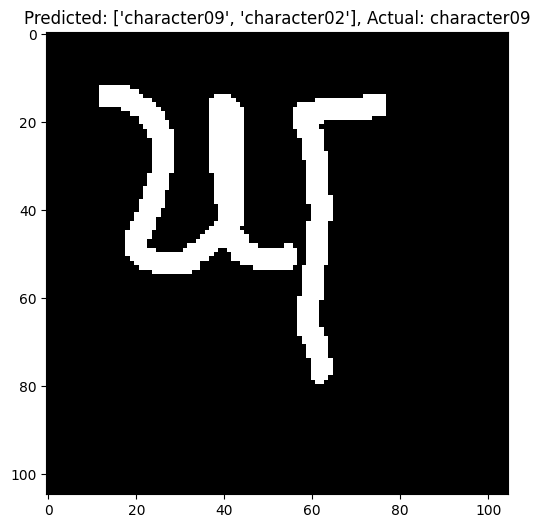

In [127]:
# Evaluation method
def plot_images_and_predictions(triplet_network, data_dict_test, preprocess, K=2, device=DEVICE):
    """
    Evaluates the Triplet network on the test data.

    :param triplet_network: The trained Triplet network.
    :param data_dict_test: Dictionary with test data. Contains keys 'annotated_images', 
                           'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
    :param K: Number of most similar images to consider.
    :param print_alphabet_accuracy: Flag to print accuracy for each alphabet.
    :param device: Device to perform computations on ('cuda' or 'cpu').
    :return: Overall accuracy of the network on the test data.
    """
    triplet_network.eval()
    correct_predictions = 0
    num_images = 0

    toPILImage = transforms.ToPILImage()

    with torch.no_grad():

        # Plot all the labelled images from a random alphabet in the test data
        alphabets_test = list(data_dict_test['annotated_images'].keys())
        alphabet_id = np.random.randint(0, len(alphabets_test))
        alphabet = alphabets_test[alphabet_id]

        alphabet_annotated = data_dict_test['annotated_images'][alphabet]
        alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]

        num_images = len(alphabet_annotated)
        print(f"Number of images in alphabet {alphabet}: {num_images}")

        num_rows = num_images // 5 + (num_images % 5 > 0)  # This will round up to the nearest multiple of 5
        num_cols = 5

        plt.figure(figsize=(20, 8))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i+1)
            plt.imshow(alphabet_annotated[i].squeeze(0), cmap='gray')
            plt.title(alphabet_annotated_labels[i])
            plt.axis('off')
        

        # Preprocess and compute embeddings for annotated images
        annotated_embeddings = compute_embeddings(alphabet_annotated, triplet_network, preprocess, toPILImage, device)

        # Select 10 random unseen images
        random_idx = np.random.choice(len(data_dict_test['unseen_images'][alphabet]), 10).tolist()

        unseen_images = [data_dict_test['unseen_images'][alphabet][i] for i in random_idx]
        unseen_labels = [data_dict_test['unseen_images_labels'][alphabet][i] for i in random_idx]

        for i, unseen_image in enumerate(unseen_images):
            # Preprocess and compute embedding for unseen image
            embedding_unseen = compute_embeddings([unseen_image], triplet_network, preprocess, toPILImage, device)

            # Compute distances
            distances = F.pairwise_distance(embedding_unseen, annotated_embeddings)
            distances = distances.cpu().numpy()

            # Get the indices of the K smallest distances
            most_similar_indices = np.argsort(distances)[:K]
            # Get the corresponding labels
            most_similar_labels = [alphabet_annotated_labels[idx] for idx in most_similar_indices]

            # Get the actual label of the unseen image
            actual_label = unseen_labels[i]

            # Plot the unseen image with the predicted labels
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(unseen_image.squeeze(0), cmap='gray')
            plt.title(f"Predicted: {most_similar_labels}, Actual: {actual_label}")

plot_images_and_predictions(triplet_network, data_dict_test, preprocess, K=2, device=DEVICE)

# Task 2: rotation problem

In [128]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('data/test_data_task2.pkl')

In [129]:
data_dict_test_task2.keys()

dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])

In [130]:
# Define preprocessing steps
preprocess_rotation = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.RandomRotation(degrees=360),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),
    transforms.Grayscale(num_output_channels=1)
])

In [131]:
#  Create Triplet dataset
triplet_dataset_rotation = create_triplet_dataset(train_data, transform=preprocess_rotation)

# Define the size of the validation set
val_size = int(0.2 * len(triplet_dataset_rotation))  # 20% of the dataset
train_size = len(triplet_dataset_rotation) - val_size

# Create train and validation sets
generator = torch.Generator().manual_seed(42)
triplet_train_dataset, triplet_val_dataset = random_split(triplet_dataset_rotation, [train_size, val_size], generator=generator)

# Create data loaders
train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(triplet_val_dataset, batch_size=32, shuffle=False)

print(f"Num of training triplets: {len(triplet_train_dataset)}")
print(f"Num of validation triplets: {len(triplet_val_dataset)}")

100%|██████████| 19280/19280 [00:23<00:00, 821.02it/s] 

Num of training triplets: 293056
Num of validation triplets: 73264


In [132]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from e2cnn import gspaces
from e2cnn import nn as enn

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class EquivariantEmbeddingNet(nn.Module):
    def __init__(self):
        super(EquivariantEmbeddingNet, self).__init__()
        
        # Define a symmetry space with discrete rotations of 8 degrees
        self.r2_act = gspaces.Rot2dOnR2(N=8)

        # Define the input field: 1 channel with regular representation
        in_type = enn.FieldType(self.r2_act, [self.r2_act.trivial_repr])

        # Define the output fields for the various convolutional layers
        out_type1 = enn.FieldType(self.r2_act, 8*[self.r2_act.regular_repr])
        out_type2 = enn.FieldType(self.r2_act, 16*[self.r2_act.regular_repr])
        out_type3 = enn.FieldType(self.r2_act, 32*[self.r2_act.regular_repr])

        # Initial layer to adapt the number of channels
        self.initial_conv = enn.R2Conv(in_type, out_type1, kernel_size=3, padding=1)

        # Build the sequential convolutional network
        self.conv_layers = enn.SequentialModule(
            # First convolutional block
            enn.R2Conv(in_type, out_type1, kernel_size=3, padding=1),
            enn.InnerBatchNorm(out_type1),
            enn.ReLU(out_type1, inplace=True),
            enn.R2Conv(out_type1, out_type1, kernel_size=3, padding=1),
            enn.ReLU(out_type1, inplace=True),
            enn.PointwiseMaxPool(out_type1, kernel_size=2, stride=2),

            # Second convolutional block
            enn.R2Conv(out_type1, out_type2, kernel_size=3, padding=1),
            enn.InnerBatchNorm(out_type2),
            enn.ReLU(out_type2, inplace=True),
            enn.R2Conv(out_type2, out_type2, kernel_size=3, padding=1),
            enn.ReLU(out_type2, inplace=True),
            enn.PointwiseMaxPool(out_type2, kernel_size=2, stride=2),

            # Third convolutional block
            enn.R2Conv(out_type2, out_type3, kernel_size=3, padding=1),
            enn.InnerBatchNorm(out_type3),
            enn.ReLU(out_type3, inplace=True),
            enn.R2Conv(out_type3, out_type3, kernel_size=3, padding=1),
            enn.ReLU(out_type3, inplace=True),
            enn.PointwiseMaxPool(out_type3, kernel_size=2, stride=2),
        )

        self.input_type = in_type
        
        # Fully connected layers
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Input: create a GeometricTensor from the input tensor
        x = enn.GeometricTensor(x, self.input_type)
        
        # Pass through the sequential convolutional blocks
        x = self.conv_layers(x)
        
        x = x.tensor

        # Flatten and pass through the fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)


In [133]:
import torch
import torch.nn.functional as F

def rotational_consistency_loss(triplet_network, image, rotated_image):
    """
    Compute the rotational consistency loss between the embeddings of the original and rotated images.

    :param embedding_net: The embedding network.
    :param image: The original image.
    :param rotated_image: The rotated image.
    :return: The rotational consistency loss.
    """
    embedding = triplet_network.get_embedding(image)
    rotated_embedding = triplet_network.get_embedding(rotated_image)
    loss = F.mse_loss(embedding, rotated_embedding)
    return loss

In [134]:
def rotate_image(image):
    """
    Rotate the image by a random angle.

    :param image: The input image.
    :return: The rotated image.
    """
    random_rotation = transforms.RandomRotation(degrees=(0, 360))
    rotated_image = random_rotation(image)
    return rotated_image


In [135]:
# Function to train Triplet network
def train_triplet_network_rotation(triplet_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001, device=DEVICE):
    """
    Trains a triplet network for a specified number of epochs.

    The function takes as input a triplet network, training and validation data loaders, number of epochs, and learning rate.
    It uses the Adam optimizer and a custom TripletLoss criterion.
    For each epoch, it iterates over the training data, computes the loss and backpropagates the gradients.
    It also computes the AUC-ROC for each batch and keeps a running total.
    After each epoch, it evaluates the network on the validation data and computes the average loss and AUC-ROC.

    Parameters:
    triplet_network (nn.Module): The triplet network to train.
    train_loader (DataLoader): The DataLoader for the training data.
    val_loader (DataLoader): The DataLoader for the validation data.
    num_epochs (int, optional): The number of epochs to train for. Default is 10.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    None
    """
    criterion = TripletLoss().to(device)
    optimizer = optim.Adam(triplet_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        triplet_network.train()

        running_loss = 0.0
        running_distance = 0.0
        batch_count = 0

        for img1, img2, img3 in progress_bar:
            optimizer.zero_grad()
            img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
            output1, output2, output3 = triplet_network(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            # Compute rotational consistency loss
            rotated_anchor = rotate_image(img1)
            rotated_anchor = rotated_anchor.to(device)
            rot_loss = rotational_consistency_loss(triplet_network, img1, rotated_anchor)
            loss += rot_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
            running_distance += distance
            batch_count += 1

            # Update the progress bar with the current loss and distance
            progress_bar.set_postfix({"loss": running_loss / batch_count, "distance": running_distance / batch_count})

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Distance: {running_distance/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        triplet_network.eval()
        running_val_loss = 0.0
        running_val_distance = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, img3 in progress_bar:
                img1, img2, img3 = img1.to(device), img2.to(device), img3.to(device)
                output1, output2, output3 = triplet_network(img1, img2, img3)
                val_loss = criterion(output1, output2, output3)
                running_val_loss += val_loss.item()
                val_distance = compute_distance_triplet(output1.detach(), output2.detach(), output3.detach())
                running_val_distance += val_distance
                batch_count += 1

                # Update the progress bar with the current loss and distance
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_distance": running_val_distance / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Distance: {running_val_distance/len(val_loader)}")

In [136]:
equivariant_triplet_net = TripletNet(EquivariantEmbeddingNet()).to(DEVICE)

In [137]:
# train the rotation invariant triplet network
if TRAIN_TRIPLET_ROTATION:
    train_triplet_network_rotation(equivariant_triplet_net, train_loader, val_loader, num_epochs=2, learning_rate=0.0001)
    # Save the trained Siamese network
    torch.save(equivariant_triplet_net.state_dict(), 'rotation_invariant_triplet_network.pth')

## Testing

### Random Baseline

In [141]:
random_prediction(data_dict_test_task2)

100%|██████████| 20/20 [00:00<00:00, 648.36it/s]


Accuracy for k=1: 0.027953038894656976


100%|██████████| 20/20 [00:00<00:00, 751.91it/s]


Accuracy for k=2: 0.05718393099592684


100%|██████████| 20/20 [00:00<00:00, 600.73it/s]


Accuracy for k=4: 0.12323296861273061


100%|██████████| 20/20 [00:00<00:00, 321.82it/s]

Accuracy for k=8: 0.23951761041450365


### Evaluate Equivariant Network

#### Baseline

In [142]:
# Load the trained rotation invariant triplet network
basic_triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)
triplet_network.load_state_dict(torch.load(main_dir + 'triplet_network.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [143]:
# Evaluate the rotation invariant triplet network
accuracy_1_basic = evaluate_triplet_network(basic_triplet_network, data_dict_test_task2, preprocess_rotation, K=1, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_2_basic = evaluate_triplet_network(basic_triplet_network, data_dict_test_task2, preprocess_rotation, K=2, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_4_basic = evaluate_triplet_network(basic_triplet_network, data_dict_test_task2, preprocess_rotation, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_8_basic = evaluate_triplet_network(basic_triplet_network, data_dict_test_task2, preprocess_rotation, K=8, print_alphabet_accuracy=print_alphabet_accuracy)

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


In [144]:
print(f"Accuracy for k=1: {accuracy_1_basic}")
print(f"Accuracy for k=2: {accuracy_2_basic}")
print(f"Accuracy for k=4: {accuracy_4_basic}")
print(f"Accuracy for k=8: {accuracy_8_basic}")

Accuracy for k=1: 0.05814232090088651
Accuracy for k=2: 0.09703697787716636
Accuracy for k=4: 0.17770146154460506
Accuracy for k=8: 0.31770625349412984


#### Rotation Equivariant

In [145]:
rotation_invariant_triplet_net = TripletNet(EquivariantEmbeddingNet()).to(DEVICE)
rotation_invariant_triplet_net.load_state_dict(torch.load(main_dir + 'rotation_invariant_triplet_network.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [146]:
# Evaluate the rotation invariant triplet network
accuracy_1_rotation = evaluate_triplet_network(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=1, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_2_rotation = evaluate_triplet_network(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=2, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_4_rotation = evaluate_triplet_network(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_8_rotation = evaluate_triplet_network(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=8, print_alphabet_accuracy=print_alphabet_accuracy)

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [147]:
print(f"Accuracy for k=1: {accuracy_1_rotation}")
print(f"Accuracy for k=2: {accuracy_2_rotation}")
print(f"Accuracy for k=4: {accuracy_4_rotation}")
print(f"Accuracy for k=8: {accuracy_8_rotation}")

Accuracy for k=1: 0.5119399408992892
Accuracy for k=2: 0.6830125389345899
Accuracy for k=4: 0.8178260522322498
Accuracy for k=8: 0.915342225061896


### Visualise Predictions

Number of images in alphabet Glagolitic: 45


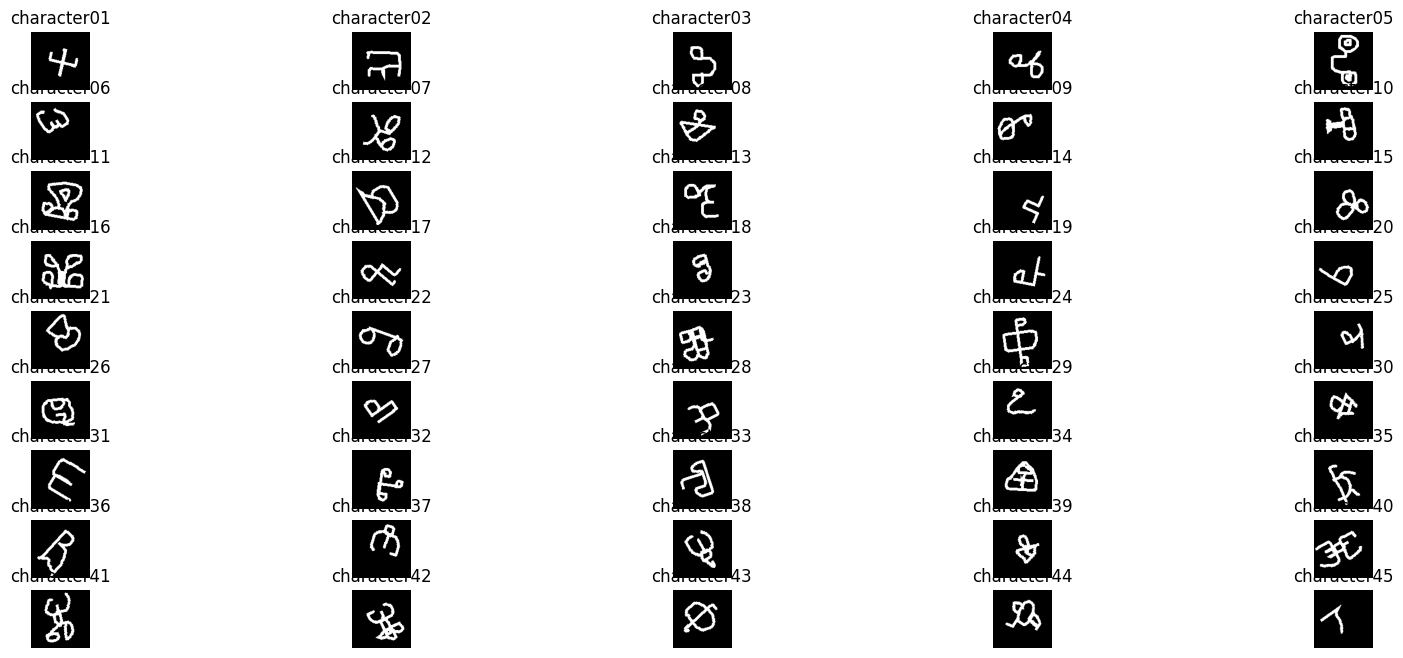

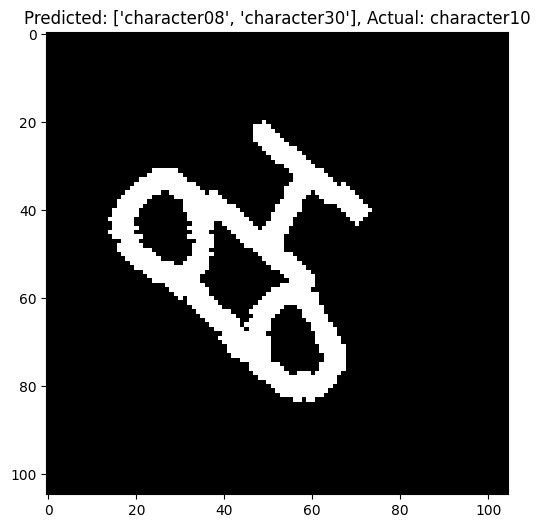

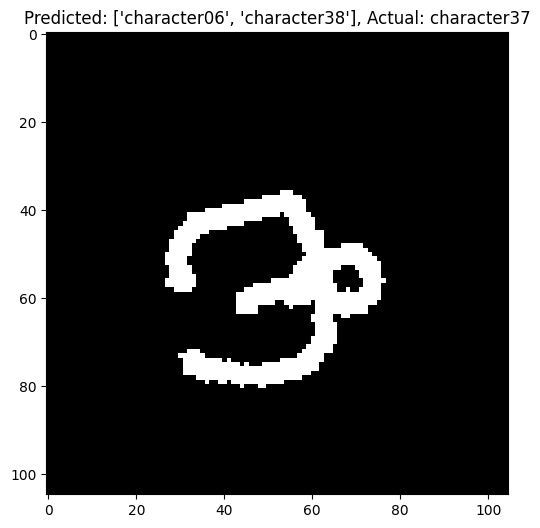

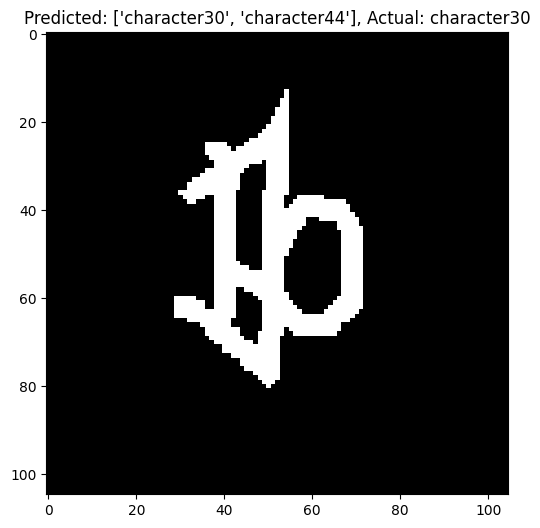

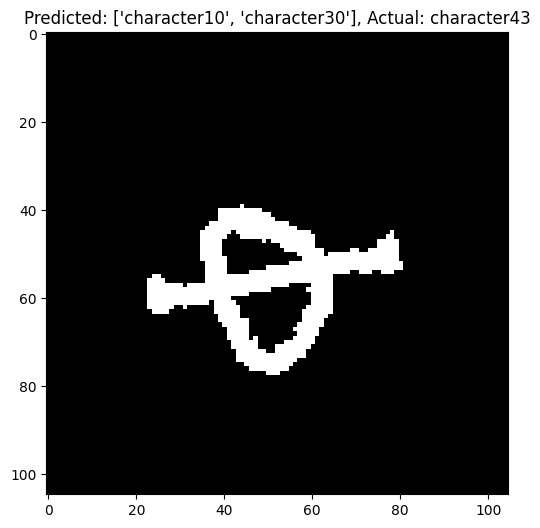

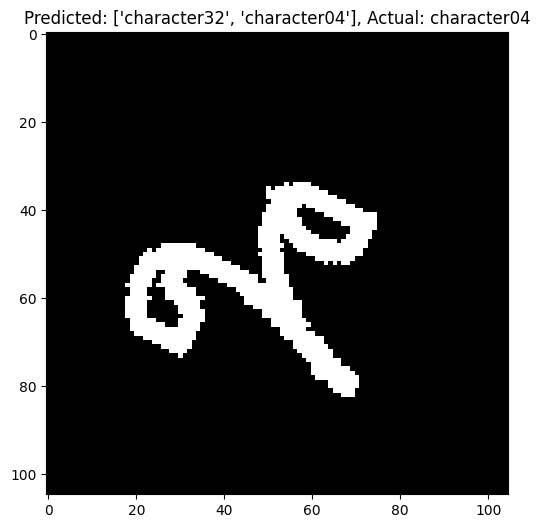

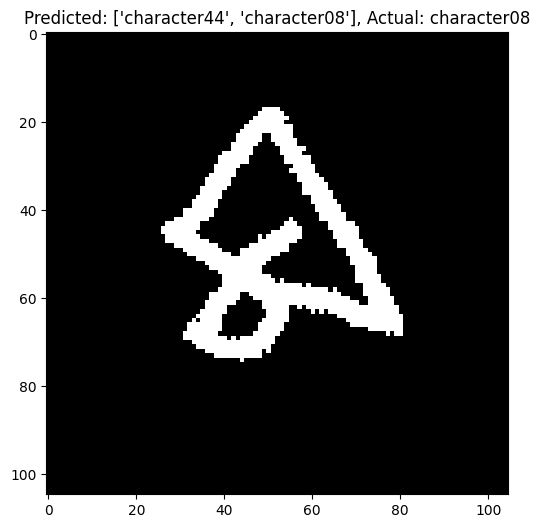

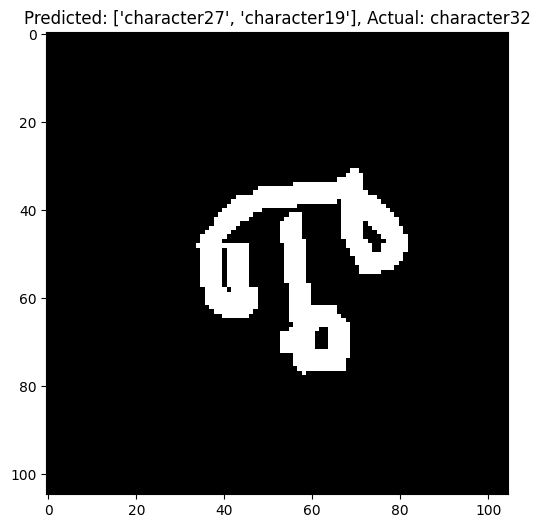

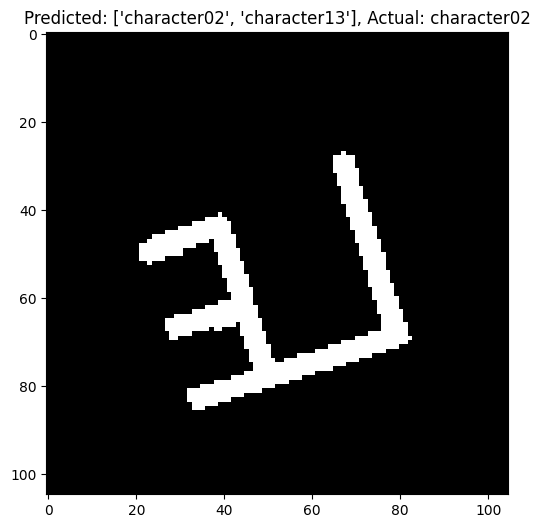

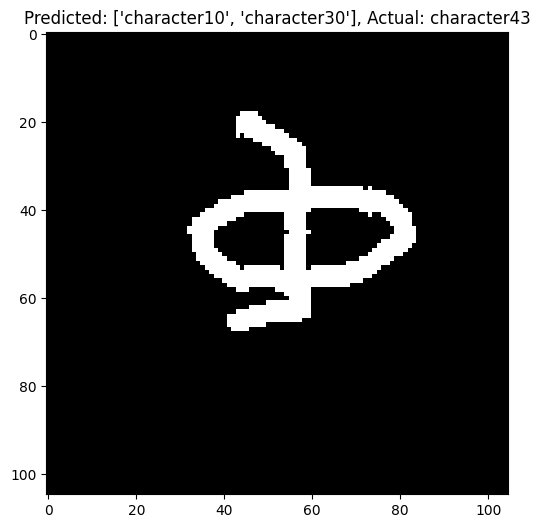

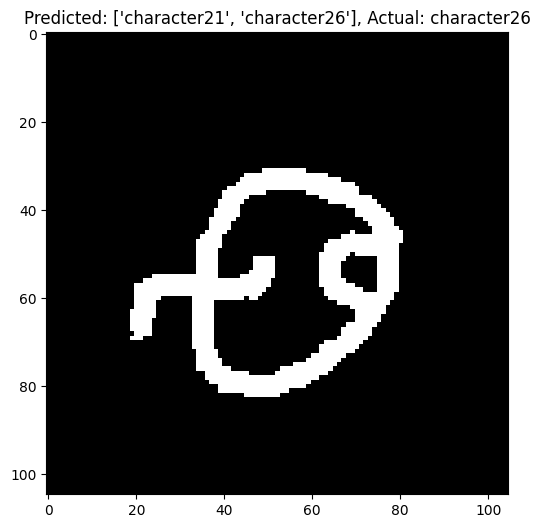

In [148]:
plot_images_and_predictions(rotation_invariant_triplet_net, data_dict_test_task2, preprocess, K=2)


### Plot Embeddings

In [149]:
import random
from sklearn.decomposition import PCA

# Function to sample images and rotate them
def sample_and_rotate_images(data_dict_test, num_images=20):
    images = []
    labels = []
    for alphabet in data_dict_test['unseen_images'].keys():
        images.extend(data_dict_test['unseen_images'][alphabet][:num_images])
        labels.extend(data_dict_test['unseen_images_labels'][alphabet][:num_images])
    
    sampled_images = random.sample(images, num_images)
    rotated_images = [rotate_image(image) for image in sampled_images]
    return sampled_images, rotated_images

# Function to perform PCA and plot embeddings
def plot_embeddings_pca(embeddings, rotated_embeddings, num_images=20):
    pca = PCA(n_components=2)
    embeddings = embeddings.cpu().detach().numpy()
    rotated_embeddings = rotated_embeddings.cpu().detach().numpy()
    combined_embeddings = np.vstack((embeddings, rotated_embeddings))
    pca.fit(combined_embeddings)
    pca_embeddings = pca.transform(embeddings)
    pca_rotated_embeddings = pca.transform(rotated_embeddings)

    colors = plt.cm.rainbow(np.linspace(0, 1, num_images))

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.scatter(pca_embeddings[i, 0], pca_embeddings[i, 1], color=colors[i], label=f"Image {i+1}")
        plt.scatter(pca_rotated_embeddings[i, 0], pca_rotated_embeddings[i, 1], color=colors[i])

    plt.title("PCA of Embeddings")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), title="Images")
    plt.show()


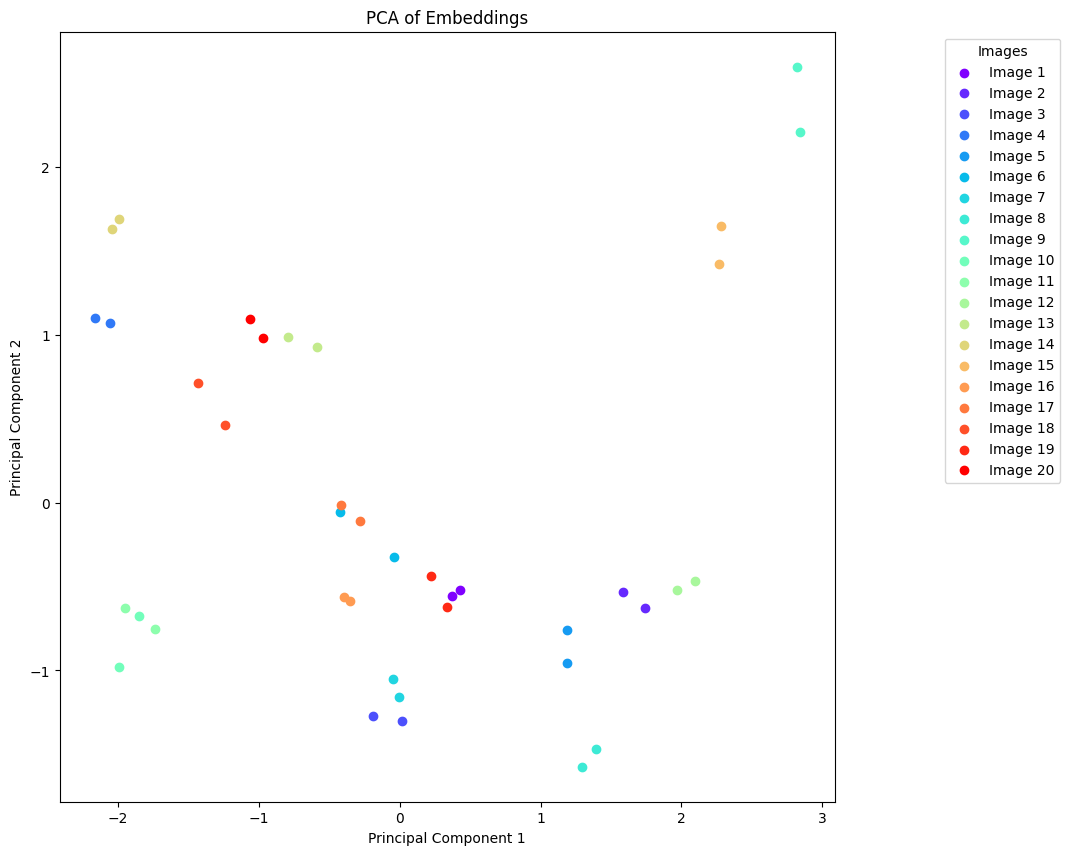

In [150]:
num_images = 20

# Sample and rotate images
sampled_images, rotated_images = sample_and_rotate_images(data_dict_test, num_images)

# Compute embeddings for the images
embeddings = compute_embeddings(sampled_images, rotation_invariant_triplet_net, preprocess, transforms.ToPILImage(), DEVICE)
rotated_embeddings = compute_embeddings(rotated_images, rotation_invariant_triplet_net, preprocess, transforms.ToPILImage(), DEVICE)

# Perform PCA and plot the results
plot_embeddings_pca(embeddings, rotated_embeddings, num_images)

# Task 3: Domain knowledge injection

In [151]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data(main_dir + 'data/test_data_task3.pkl')
print(data_dict_test_task3.keys())

dict_keys(['unseen_images_labels', 'annotated_images_labels', 'unseen_images', 'annotated_images', 'unseen_images_preceding_types', 'character_to_type_mapping', 'type_following_probs'])


In [152]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same.

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [153]:
len(data_dict_test_task3)

7

In [154]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')

type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')


Alphabet: Manipuri
Some character types that preceded unseen images from the Manipuri alphabet: ['I' 'I' 'I' 'I' 'II']
There are 760 preceding character types in the Manipuri alphabet, and 760 unseen images.
Type of character31 from the Manipuri alphabet: I
Probability of a character of type II following a character of type I in the Manipuri alphabet: 0.2467741935483871


## Probabilistic Triplet Network

In [155]:
probabilistic_triplet_network = TripletNet(EmbeddingNet()).to(DEVICE)
probabilistic_triplet_network.load_state_dict(torch.load(main_dir + 'triplet_network.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [156]:
# Function to adjust distances using sequence probabilities
def adjust_distances_with_probabilities(distances, character_to_type, type_following_probs, preceding_type, weight=1.0):
    """
    Adjusts the distances using the sequence probabilities and adds the character class.

    :param distances: List of distances between embeddings.
    :param character_to_type: Mapping from character to type.
    :param type_following_probs: Probabilities of character type following another type.
    :param preceding_type: Type of the preceding character.
    :return: List of adjusted distances, corresponding labels, and character types.
    """
    min_distance = min(distances, key=lambda x: x[0])[0]
    max_distance = max(distances, key=lambda x: x[0])[0]

    adjusted_distances = []
    for distance, label_annotated in distances:
        # Normalize the distance between 0 and 1
        normalized_distance = (distance - min_distance) / (max_distance - min_distance)
        type_annotated = character_to_type[label_annotated]  # Get the type of the annotated character
        following_probability = type_following_probs[preceding_type][type_annotated]
        adjusted_score = normalized_distance / (following_probability ** weight)  # Use inverse of probability for adjustment
        adjusted_distances.append((adjusted_score, label_annotated, following_probability))

    # Sort the list by the first element of the tuple (adjusted score)
    adjusted_distances.sort(key=lambda x: x[0])

    return adjusted_distances

## Testing

### Evaluate Probablistic Triplet Network

#### Random

In [165]:
random_prediction(data_dict_test_task3)

100%|██████████| 20/20 [00:00<00:00, 490.16it/s]


Accuracy for k=1: 0.028512099672550115


100%|██████████| 20/20 [00:00<00:00, 819.43it/s]


Accuracy for k=2: 0.05918057663125948


100%|██████████| 20/20 [00:00<00:00, 663.63it/s]


Accuracy for k=4: 0.12107659132657136


100%|██████████| 20/20 [00:00<00:00, 471.21it/s]

Accuracy for k=8: 0.24343103585975562


#### Baseline

In [157]:
accuracy_1_basic = evaluate_triplet_network(triplet_network, data_dict_test_task3, preprocess, K=1, print_alphabet_accuracy=False, device=DEVICE)
accuracy_2_basic = evaluate_triplet_network(triplet_network, data_dict_test_task3, preprocess, K=2, print_alphabet_accuracy=False, device=DEVICE)
accuracy_4_basic = evaluate_triplet_network(triplet_network, data_dict_test_task3, preprocess, K=4, print_alphabet_accuracy=False, device=DEVICE)
accuracy_8_basic = evaluate_triplet_network(triplet_network, data_dict_test_task3, preprocess, K=8, print_alphabet_accuracy=False, device=DEVICE)

100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


In [158]:
print(f"Accuracy for k=1: {accuracy_1_basic}")
print(f"Accuracy for k=2: {accuracy_2_basic}")
print(f"Accuracy for k=4: {accuracy_4_basic}")
print(f"Accuracy for k=8: {accuracy_8_basic}")

Accuracy for k=1: 0.6493890264355882
Accuracy for k=2: 0.7977797300535101
Accuracy for k=4: 0.8996885232808881
Accuracy for k=8: 0.9586295024359077


#### Probabilistic

In [159]:
# Evaluation method
def evaluate_probabilistic_triplet_network(triplet_network, data_dict_test, preprocess, weight=1.0, K=1, print_alphabet_accuracy=True, device=DEVICE):
    """
    Evaluates the Triplet network on the test data.

    :param triplet_network: The trained Triplet network.
    :param data_dict_test: Dictionary with test data. Contains keys 'annotated_images', 
                           'annotated_images_labels', 'unseen_images', 'unseen_images_labels', 
                           'unseen_images_preceding_types', 'character_to_type_mapping', 
                           'type_following_probs'.
    :param K: Number of most similar images to consider.
    :param print_alphabet_accuracy: Flag to print accuracy for each alphabet.
    :param device: Device to perform computations on ('cuda' or 'cpu').
    :return: Overall accuracy of the network on the test data.
    """
    triplet_network.eval()
    correct_predictions = 0
    num_images = 0
    toPILImage = transforms.ToPILImage()

    with torch.no_grad():
        for alphabet in tqdm(data_dict_test['annotated_images'].keys()):
            correct_predictions_alphabet = 0

            annotated_images = data_dict_test['annotated_images'][alphabet]
            annotated_labels = data_dict_test['annotated_images_labels'][alphabet]
            annotated_embeddings = compute_embeddings(annotated_images, triplet_network, preprocess, toPILImage, device)

            unseen_images = data_dict_test['unseen_images'][alphabet]
            unseen_labels = data_dict_test['unseen_images_labels'][alphabet]
            preceding_types = data_dict_test['unseen_images_preceding_types'][alphabet]
            character_to_type = data_dict_test['character_to_type_mapping'][alphabet]
            type_following_probs = data_dict_test['type_following_probs'][alphabet]

            for i, unseen_image in enumerate(unseen_images):
                preceding_type = preceding_types[i]

                embedding_unseen = compute_embeddings([unseen_image], triplet_network, preprocess, toPILImage, device)

                distances = F.pairwise_distance(embedding_unseen, annotated_embeddings)
                distances = list(zip(distances.cpu().numpy(), annotated_labels))

                adjusted_distances = adjust_distances_with_probabilities(distances, character_to_type, type_following_probs, preceding_type, weight)

                top_k_labels = [label for _, label, _ in adjusted_distances[:K]]

                actual_label = unseen_labels[i]
                if actual_label in top_k_labels:
                    correct_predictions += 1
                    correct_predictions_alphabet += 1
                num_images += 1

            accuracy_alphabet = correct_predictions_alphabet / len(unseen_images)
            if print_alphabet_accuracy:
                print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet:.4f}")

    accuracy = correct_predictions / num_images
    return accuracy

In [160]:
accuracy_1_knowledge = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, K=1, print_alphabet_accuracy=print_alphabet_accuracy, device=DEVICE, weight=0.5)
accuracy_2_knowledge = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, K=2, print_alphabet_accuracy=print_alphabet_accuracy, device=DEVICE, weight=0.5)
accuracy_4_knowledge = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy, device=DEVICE, weight=0.5)
accuracy_8_knowledge = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, K=8, print_alphabet_accuracy=print_alphabet_accuracy, device=DEVICE, weight=0.5)

  5%|▌         | 1/20 [00:00<00:18,  1.02it/s]/var/folders/43/zvsqfyrj1hlfqtzzdgxqzt080000gn/T/ipykernel_6834/2071430236.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  adjusted_score = normalized_distance / (following_probability ** weight)  # Use inverse of probability for adjustment
/var/folders/43/zvsqfyrj1hlfqtzzdgxqzt080000gn/T/ipykernel_6834/2071430236.py:21: RuntimeWarning: invalid value encountered in scalar divide
  adjusted_score = normalized_distance / (following_probability ** weight)  # Use inverse of probability for adjustment
100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


In [161]:
print(f"Accuracy for k=1: {accuracy_1_knowledge}")
print(f"Accuracy for k=2: {accuracy_2_knowledge}")
print(f"Accuracy for k=4: {accuracy_4_knowledge}")
print(f"Accuracy for k=8: {accuracy_8_knowledge}")

Accuracy for k=1: 0.6523440619758806
Accuracy for k=2: 0.8088810797859596
Accuracy for k=4: 0.9051992652344062
Accuracy for k=8: 0.9598274898171073


### Visualise Predictions

Number of images in alphabet Tengwar: 25


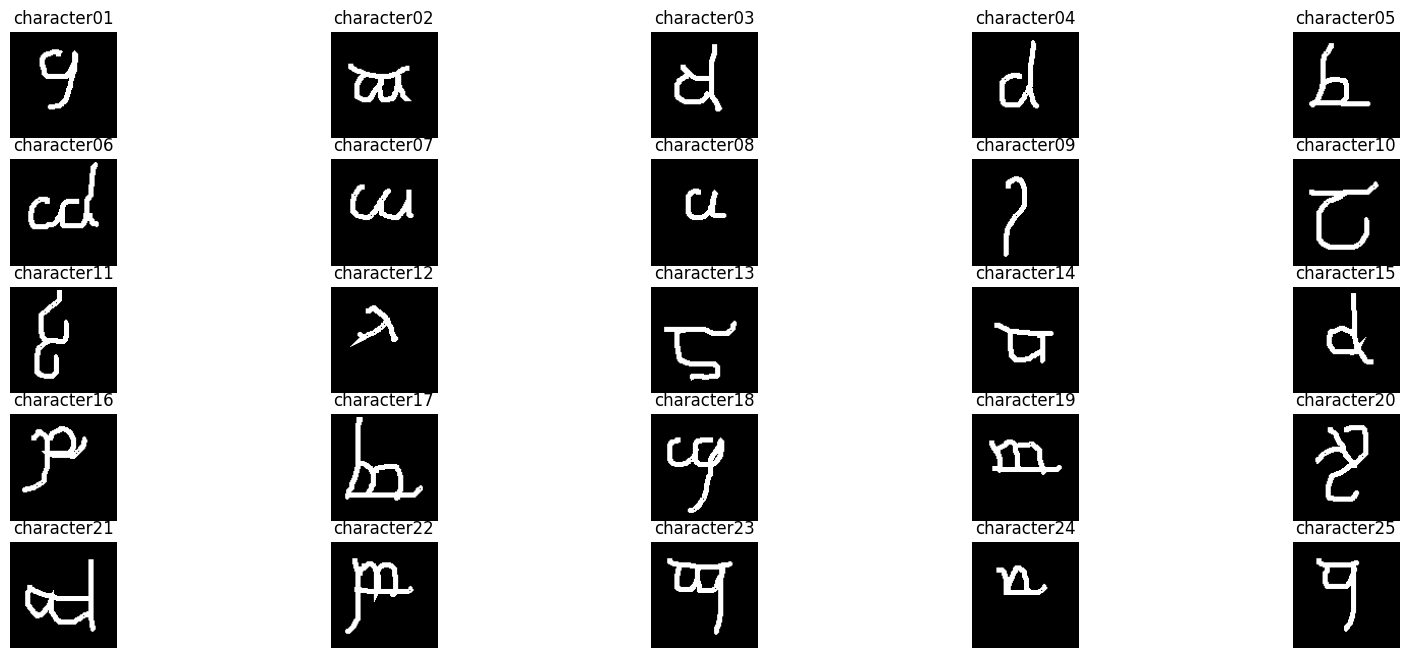

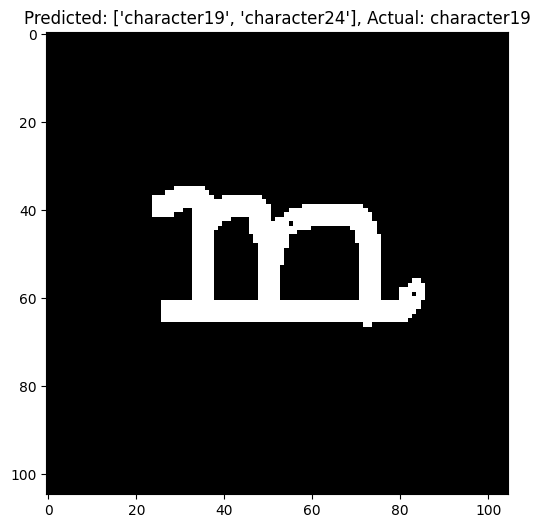

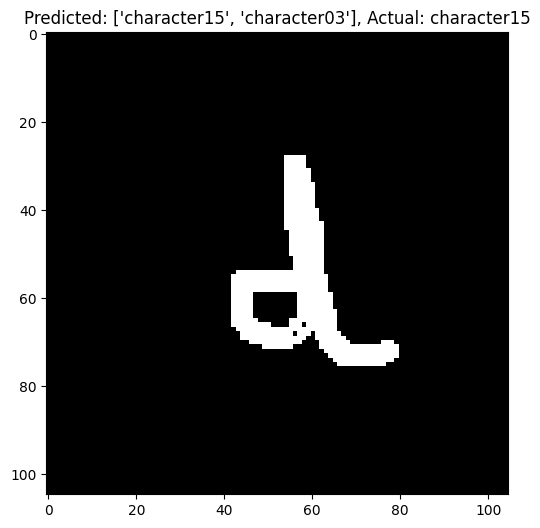

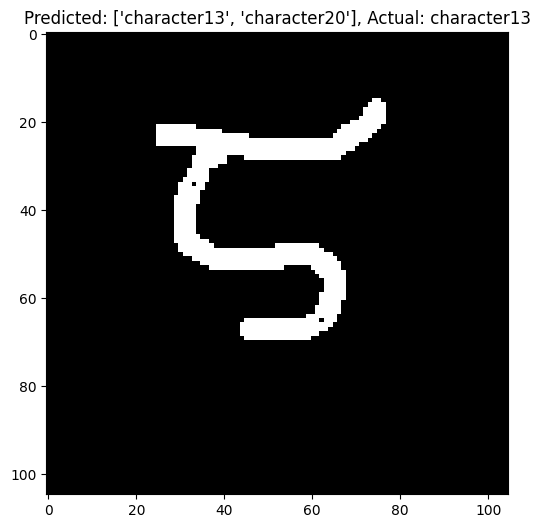

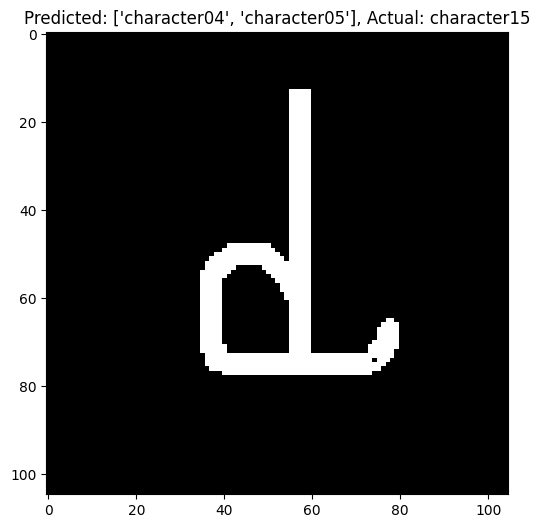

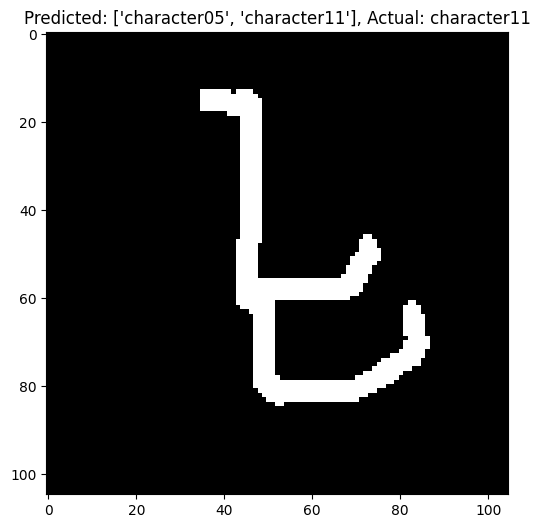

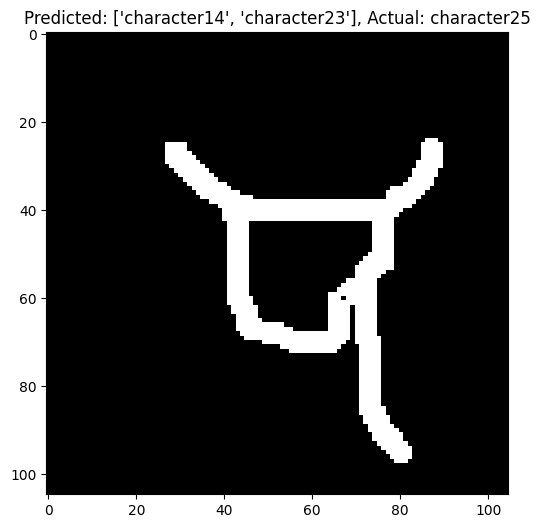

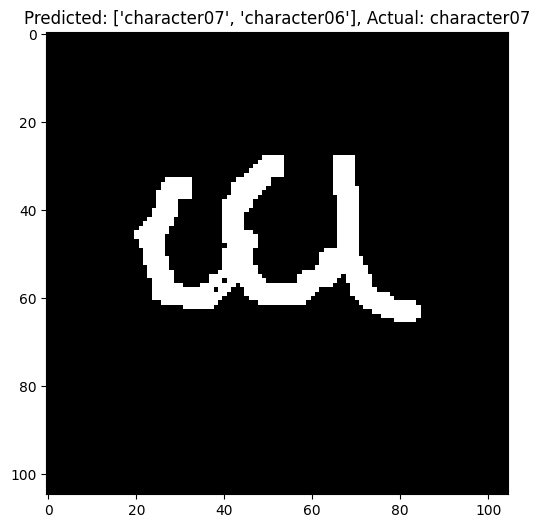

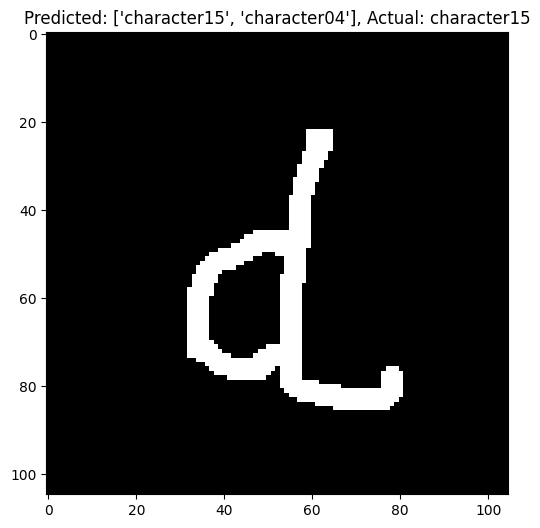

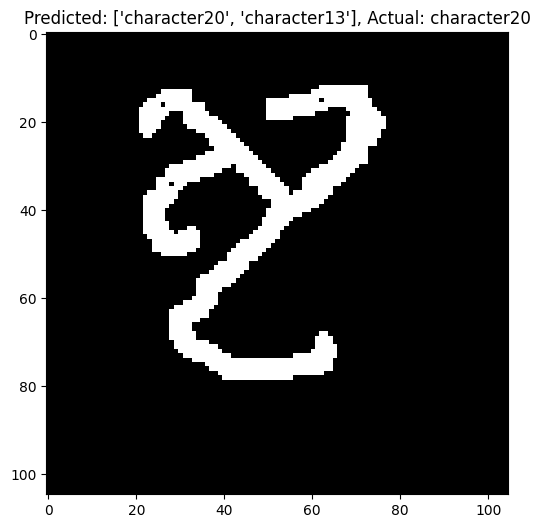

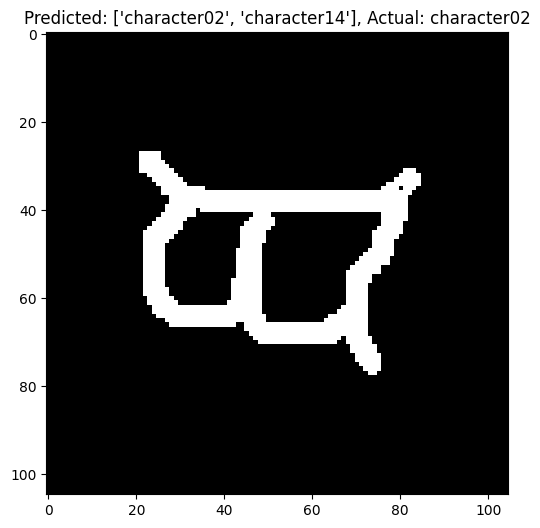

In [162]:
plot_images_and_predictions(probabilistic_triplet_network, data_dict_test_task3, preprocess, K=2, device=DEVICE)

### Weight Tuning

  0%|          | 0/6 [00:00<?, ?it/s]/var/folders/43/zvsqfyrj1hlfqtzzdgxqzt080000gn/T/ipykernel_6834/2071430236.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  adjusted_score = normalized_distance / (following_probability ** weight)  # Use inverse of probability for adjustment
/var/folders/43/zvsqfyrj1hlfqtzzdgxqzt080000gn/T/ipykernel_6834/2071430236.py:21: RuntimeWarning: invalid value encountered in scalar divide
  adjusted_score = normalized_distance / (following_probability ** weight)  # Use inverse of probability for adjustment
100%|██████████| 6/6 [12:31<00:00, 125.19s/it]


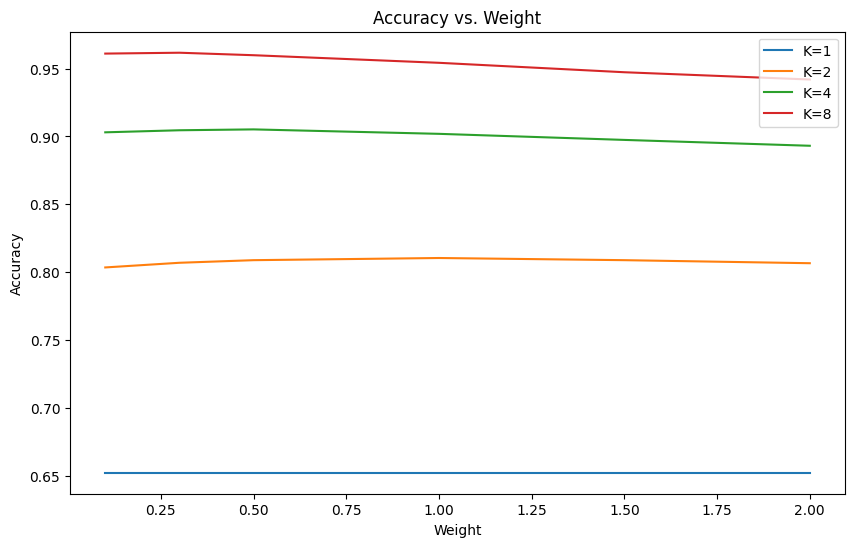

In [163]:
# Evaluate model with different values of weight
weights = [0.1, 0.3, 0.5, 1.0, 1.5, 2.0]
accuracies_1 = []
accuracies_2 = []
accuracies_4 = []
accuracies_8 = []

for weight in tqdm(weights):
    accuracy_1 = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, weight, K=1, print_alphabet_accuracy=False)
    accuracy_2 = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, weight, K=2, print_alphabet_accuracy=False)
    accuracy_4 = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, weight, K=4, print_alphabet_accuracy=False)
    accuracy_8 = evaluate_probabilistic_triplet_network(probabilistic_triplet_network, data_dict_test_task3, preprocess, weight, K=8, print_alphabet_accuracy=False)
    accuracies_1.append(accuracy_1)
    accuracies_2.append(accuracy_2)
    accuracies_4.append(accuracy_4)
    accuracies_8.append(accuracy_8)

plt.figure(figsize=(10, 6))
plt.plot(weights, accuracies_1, label='K=1')
plt.plot(weights, accuracies_2, label='K=2')
plt.plot(weights, accuracies_4, label='K=4')
plt.plot(weights, accuracies_8, label='K=8')
plt.xlabel('Weight')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Weight')
plt.legend()
plt.show()

In [164]:
print(accuracies_1)
print(accuracies_2)
print(accuracies_4)
print(accuracies_8)

[0.6523440619758806, 0.6523440619758806, 0.6523440619758806, 0.6523440619758806, 0.6523440619758806, 0.6523440619758806]
[0.8035300694832681, 0.8069642999760402, 0.8088810797859596, 0.8104783962942257, 0.8088810797859596, 0.806644836674387]
[0.9030428879482469, 0.9045603386310997, 0.9051992652344062, 0.9019247663924607, 0.8974522801693156, 0.893139525596997]
[0.9610254771983069, 0.9616644038016133, 0.9598274898171073, 0.9542368820381759, 0.9472885552272182, 0.9419375449245267]
